<a href="https://colab.research.google.com/github/saritmaitra/mathews_correlation_coefficient/blob/main/Mathews_Correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyforest
from pyforest import *
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, \
roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
df = pd.read_csv('bank_fraud.txt', delimiter = "\t")
print(df.info())

<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            1048575 non-null  int64  
 1   type            1048575 non-null  object 
 2   amount          1048575 non-null  float64
 3   nameOrig        1048575 non-null  object 
 4   oldbalanceOrg   1048575 non-null  float64
 5   newbalanceOrig  1048575 non-null  float64
 6   nameDest        1048575 non-null  object 
 7   oldbalanceDest  1048575 non-null  float64
 8   newbalanceDest  1048575 non-null  float64
 9   isFraud         1048575 non-null  int64  
 10  isFlaggedFraud  1048575 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 88.0+ MB
None


<IPython.core.display.Javascript object>

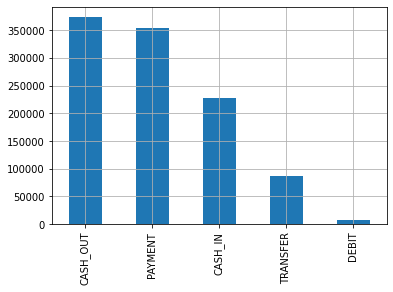

In [ ]:
df['type'].value_counts().plot(kind = 'bar')
plt.grid(True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

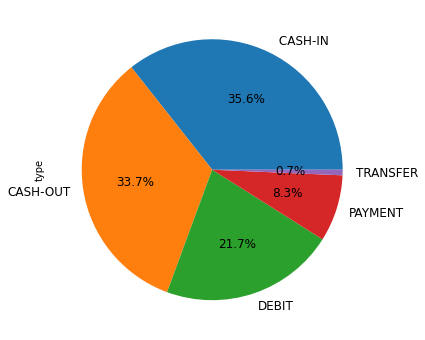

In [ ]:
fig = plt.figure(figsize=(10,6))
ax = (df['type'].value_counts()*100.0 /len(df))\
.plot.pie(autopct='%.1f%%', labels = [' CASH-IN', 'CASH-OUT', 'DEBIT', 'PAYMENT', 'TRANSFER'],
         fontsize=12)                                                                           
plt.show()

In [ ]:
X = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]

randomState = 42
np.random.seed(randomState)

y = X['isFraud']
del X['isFraud']

# Eliminate columns shown to be irrelevant for analysis in the EDA
X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

# Binary-encoding of labelled data in 'type'
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int) # convert dtype('O') to dtype(int)
print(X.info())

<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>
Int64Index: 460394 entries, 2 to 1048570
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            460394 non-null  int64  
 1   type            460394 non-null  int64  
 2   amount          460394 non-null  float64
 3   oldbalanceOrg   460394 non-null  float64
 4   newbalanceOrig  460394 non-null  float64
 5   oldbalanceDest  460394 non-null  float64
 6   newbalanceDest  460394 non-null  float64
dtypes: float64(5), int64(2)
memory usage: 28.1 MB
None


In [ ]:
X['errorBalanceOrig'] = X.newbalanceOrig + X.amount - X.oldbalanceOrg
X['errorBalanceDest'] = X.oldbalanceDest + X.amount - X.newbalanceDest
print(X.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 460394 entries, 2 to 1048570
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   step              460394 non-null  int64  
 1   type              460394 non-null  int64  
 2   amount            460394 non-null  float64
 3   oldbalanceOrg     460394 non-null  float64
 4   newbalanceOrig    460394 non-null  float64
 5   oldbalanceDest    460394 non-null  float64
 6   newbalanceDest    460394 non-null  float64
 7   errorBalanceOrig  460394 non-null  float64
 8   errorBalanceDest  460394 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 35.1 MB
None


The plot below shows how the fraudulent and genuine transactions yield different plots when their dispersion is viewed over time. 

It is clear that fradulent transactions are more homogenously distributed over time compared to genuine transactions. Also apparent is that CASH-OUTs outnumber TRANSFERs in genuine transactions, in contrast to a balanced distribution between them in fraudulent transactions. Note that the the width of each 'fingerprint' is set by the 'jitter' parameter in the plotStrip function above which attempts to separate out and plot transactions occuring at the same time with different abscissae.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

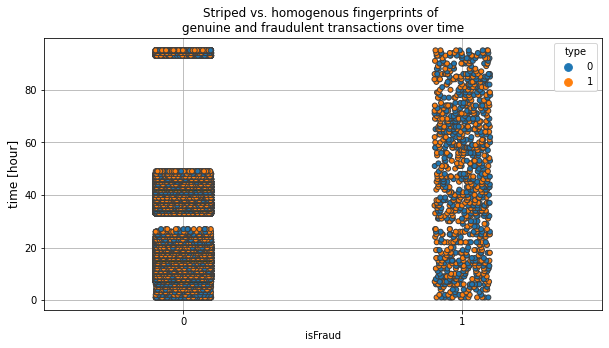

In [ ]:
import seaborn as sns

limit = len(X)
plt.figure(figsize=(10,5))
ax = sns.stripplot(y[:limit], X.step[:limit], 
                   X.type[:limit], linewidth=1)
ax.set_ylabel('time [hour]', size = 12)
ax.set_title('Striped vs. homogenous fingerprints of \ngenuine and fraudulent \
transactions over time', size = 12);
plt.grid(True)

The two plots below shows that although the presence of fraud in a transaction can be discerned by the original amount feature, the new errorBalanceDest feature is more effective at making a distinction.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

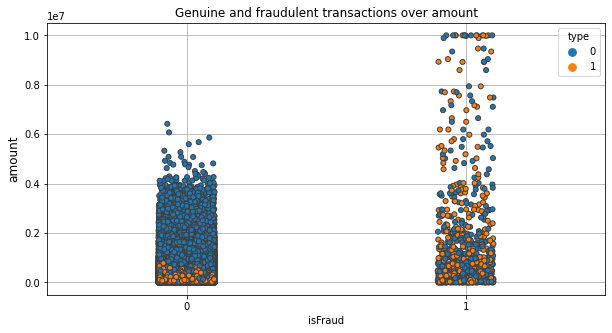

In [ ]:
plt.figure(figsize=(10,5))
ax = sns.stripplot(y[:limit], X.amount[:limit], 
                   X.type[:limit], linewidth=1)
ax.set_ylabel('amount', size = 12)
ax.set_title('Genuine and fraudulent transactions over amount', size = 12);
plt.grid(True)

## Dispersion over error in balance in destination accounts

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

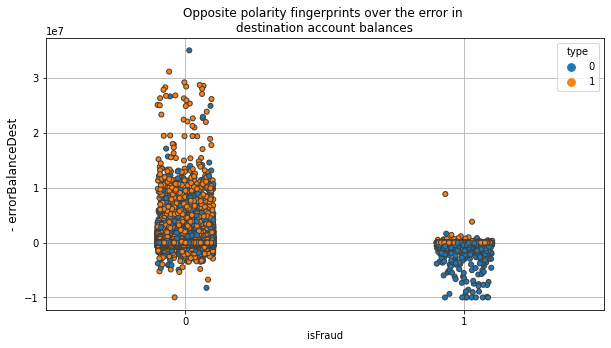

In [ ]:
plt.figure(figsize=(10,5))
ax = sns.stripplot(y[:limit], - X.errorBalanceDest[:limit], 
                   X.type[:limit], linewidth=1, jitter=True)
ax.set_ylabel('- errorBalanceDest', size = 12)
ax.set_title('Opposite polarity fingerprints over the error in \
\ndestination account balances', size = 12);
plt.grid(True)

In [ ]:
X.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,errorBalanceOrig,errorBalanceDest
2,1,0,181.00,181.0,0.0,0.0,0.00,0.00,181.0
3,1,1,181.00,181.0,0.0,21182.0,0.00,0.00,21363.0
15,1,1,229133.94,15325.0,0.0,5083.0,51513.44,213808.94,182703.5
19,1,0,215310.30,705.0,0.0,22425.0,0.00,214605.30,237735.3
24,1,0,311685.89,10835.0,0.0,6267.0,2719172.89,300850.89,-2401220.0


In [ ]:
Xfraud = X.loc[y == 1] # update Xfraud & XnonFraud with cleaned data
XnonFraud = X.loc[y == 0]

<IPython.core.display.Javascript object>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

In [ ]:
X['type'].value_counts().plot(kind = 'bar')
plt.grid(True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

skew = 0.002480484107090883


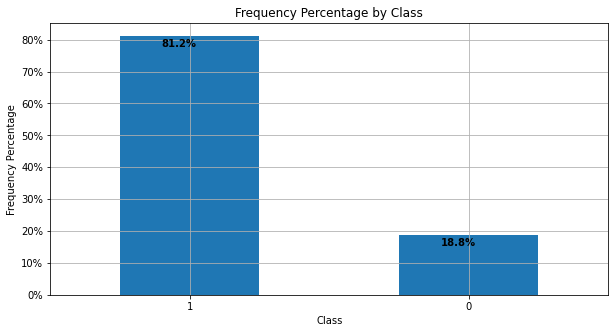

In [ ]:
import matplotlib.ticker as mtick

def bar_plot():
  plt.figure(figsize=(10,5))
  ax = (X['type'].value_counts()*100.0 /len(X['type'])).plot(kind='bar', stacked = True, rot = 0)
  ax.yaxis.set_major_formatter(mtick.PercentFormatter())
  ax.set_ylabel('Frequency Percentage')
  ax.set_xlabel('Class')
  ax.set_title('Frequency Percentage by Class')
  plt.grid(True)

  totals = []  # list to collect the plt.patches data

  # values and append to list
  for i in ax.patches:
      totals.append(i.get_width())

  total = sum(totals)  # setting individual bar lables using above list

  for i in ax.patches:
      ax.text(i.get_x()+.15, i.get_height()-3.5, \
              str(round((i.get_height()/total), 1))+'%', color='black', weight = 'bold')
  return plt

plt = bar_plot()
print('skew = {}'.format( len(Xfraud) / float(len(X)) ))


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline 
from sklearn.metrics import average_precision_score
from sklearn.metrics import cohen_kappa_score

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7, 
                                                    random_state=2021,
                                                    stratify=y)

weights = (y == 0).sum() / (1.0 * (y == 1).sum())

# Continue fitting the model and obtain predictions
model = LGBMClassifier(scale_pos_weight = weights).fit(X_train, y_train)

# Get model performance metrics
y_pred = model.predict(X_test)

# classification report and confusion matrix 
print('Classifcation report:\n', classification_report(y_test, y_pred))
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred)); print()
print('Recall: ', round(recall_score(y_test, y_pred)*100, 2)); 
# average precision and the PR curve
average_precision = round(average_precision_score(y_test, y_pred)*100, 2)
print('Precision:', average_precision)
print('Cohen Kappa: '+ str(np.round(cohen_kappa_score(y_test, y_pred),3)))
print('Mathews correlation coefficient:', 
      round(matthews_corrcoef(y_test, y_pred, sample_weight=None)*100,2))

# Predict probabilities
probabilities = model.predict_proba(X_test)

#  ROC score
print('ROC Score:', round(roc_auc_score(y_test, probabilities[:,1])*100, 2))

<IPython.core.display.Javascript object>

Classifcation report:
               precision    recall  f1-score   support

           0       1.00      0.64      0.78    137776
           1       0.01      0.96      0.01       343

    accuracy                           0.64    138119
   macro avg       0.50      0.80      0.39    138119
weighted avg       1.00      0.64      0.78    138119

Confusion matrix:
 [[87547 50229]
 [   14   329]]

Recall:  95.92
Precision: 0.63


<IPython.core.display.Javascript object>

Cohen Kappa: 0.008
Mathews correlation coefficient: 6.14
ROC Score: 78.93


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

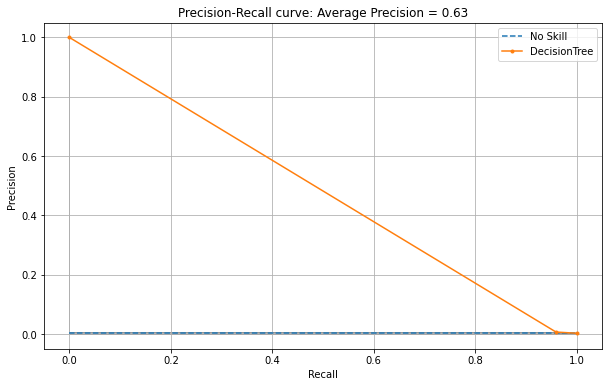

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

precision, recall, _ = precision_recall_curve(y_test, y_pred)

plt.figure(figsize=(10,6))
no_skill = len(y[y==1]) / len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='DecisionTree')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.legend(); plt.grid(True)
plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))
plt.show()

## Random Over Sample- Minority Class

In [ ]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

# oversampling the minority class
# random_over_sample = RandomOverSampler(sampling_strategy='minority')
# X_roc, y_roc =  random_over_sample.fit_sample(X_train, y_train)

# pipeline
steps = [('random_over_sample', RandomOverSampler(sampling_strategy='minority')), 
         ('model', LGBMClassifier(scale_pos_weight = weights))]
pipeline = Pipeline(steps=steps).fit(X_train, y_train) 
y_pred = pipeline.predict(X_test)

# classification report and confusion matrix 
print('Classifcation report:\n', classification_report(y_test, y_pred))
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred)); print()
print('Recall: ', round(recall_score(y_test, y_pred)*100, 2)); 
# average precision and the PR curve
average_precision = round(average_precision_score(y_test, y_pred)*100, 2)
print('Precision:', average_precision)
print('Cohen Kappa: '+ str(np.round(cohen_kappa_score(y_test, y_pred),3)))
print('Mathews correlation coefficient:', 
      round(matthews_corrcoef(y_test, y_pred, sample_weight=None)*100,2))

# Predict probabilities
probabilities = pipeline.predict_proba(X_test)

#  ROC score
print('ROC Score:', round(roc_auc_score(y_test, probabilities[:,1])*100, 2))


Classifcation report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    137776
           1       0.90      0.99      0.94       343

    accuracy                           1.00    138119
   macro avg       0.95      0.99      0.97    138119
weighted avg       1.00      1.00      1.00    138119

Confusion matrix:
 [[137740     36]
 [     5    338]]

Recall:  98.54
Precision: 89.06


<IPython.core.display.Javascript object>

Cohen Kappa: 0.943
Mathews correlation coefficient: 94.36
ROC Score: 99.34


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

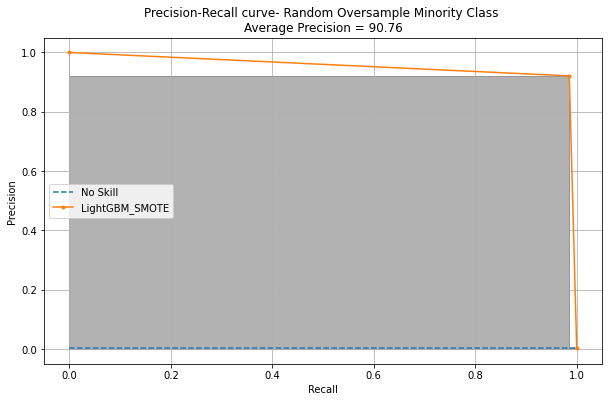

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)

plt.figure(figsize=(10,6))
# calculate the no skill line as the proportion of the positive class
no_skill = len(y[y==1]) / len(y)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

# plot the model precision-recall curve
plt.plot(recall, precision, marker='.', label='LightGBM_SMOTE')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(); plt.grid(True)
plt.title('Precision-Recall curve- Random Oversample Minority Class \nAverage Precision = {0:0.2f}'.format(average_precision))
plt.show()

## SMOTE

In [ ]:
# method = SMOTE(kind='borderline1')
# X_smote, y_smote =  method.fit_resample(X_train, y_train)

steps = ([('SMOTE', BorderlineSMOTE()), 
          ('MODEL', LGBMClassifier(scale_pos_weight = weights))])
pipeline = Pipeline(steps=steps).fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# classification report and confusion matrix 
print('Classifcation report:\n', classification_report(y_test, y_pred))
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred)); print()
print('Recall: ', round(recall_score(y_test, y_pred)*100, 2)); 
# average precision and the PR curve
average_precision = round(average_precision_score(y_test, y_pred)*100, 2)
print('Precision:', average_precision)
print('Cohen Kappa: '+ str(np.round(cohen_kappa_score(y_test, y_pred),3)))
print('Mathews correlation coefficient:', 
      round(matthews_corrcoef(y_test, y_pred, sample_weight=None)*100,2))

# Predict probabilities
probabilities = pipeline.predict_proba(X_test)

#  ROC score
print('ROC Score:', round(roc_auc_score(y_test, probabilities[:,1])*100, 2))


Classifcation report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    137776
           1       0.99      0.99      0.99       343

    accuracy                           1.00    138119
   macro avg       0.99      0.99      0.99    138119
weighted avg       1.00      1.00      1.00    138119

Confusion matrix:
 [[137771      5]
 [     5    338]]

Recall:  98.54
Precision: 97.11


<IPython.core.display.Javascript object>

Cohen Kappa: 0.985
Mathews correlation coefficient: 98.54
ROC Score: 99.69


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

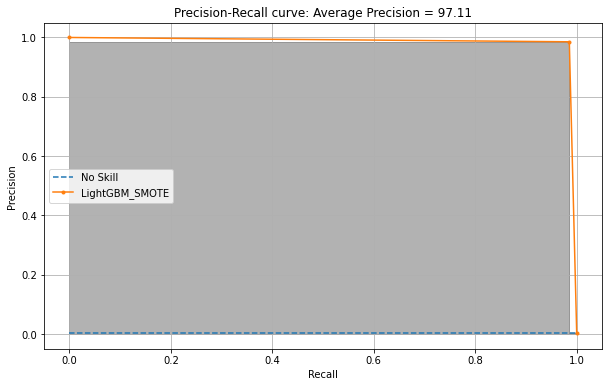

In [ ]:
# Obtain precision and recall 
precision, recall, _ = precision_recall_curve(y_test, y_pred)

plt.figure(figsize=(10,6))
# calculate the no skill line as the proportion of the positive class
no_skill = len(y[y==1]) / len(y)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='LightGBM_SMOTE')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(); plt.grid(True)
plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))
plt.show()

In [ ]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_test, y_pred, sample_weight=None)

0.9839494828299702

In [ ]:
from math import sqrt
def mcc(tp, fp, tn, fn):

    # https://stackoverflow.com/a/56875660/992687
    x = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    return ((tp * tn) - (fp * fn)) / sqrt(x)

In [ ]:
from imblearn.over_sampling import ADASYN

# adasyn_over_sample = ADASYN(sampling_strategy='minority')
# X_adasyn, y_adasyn =  adasyn_over_sample.fit_resample(X_train, y_train)

steps = ([('ADASYN', ADASYN(sampling_strategy='minority')), 
          ('MODEL', LGBMClassifier(scale_pos_weight = weights))])
pipeline = Pipeline(steps=steps).fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# classification report and confusion matrix 
print('Classifcation report:\n', classification_report(y_test, y_pred))
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred)); print()
print('Recall: ', round(recall_score(y_test, y_pred)*100, 2)); 
# average precision and the PR curve
average_precision = round(average_precision_score(y_test, y_pred)*100, 2)
print('Precision:', average_precision)
print('Cohen Kappa: '+ str(np.round(cohen_kappa_score(y_test, y_pred),3)))
print('Mathews correlation coefficient:', 
      round(matthews_corrcoef(y_test, y_pred, sample_weight=None)*100,2))

# Predict probabilities
probabilities = pipeline.predict_proba(X_test)

#  ROC score
print('ROC Score:', round(roc_auc_score(y_test, probabilities[:,1])*100, 2))


Classifcation report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99    137776
           1       0.12      0.99      0.22       343

    accuracy                           0.98    138119
   macro avg       0.56      0.98      0.61    138119
weighted avg       1.00      0.98      0.99    138119

Confusion matrix:
 [[135386   2390]
 [     5    338]]

Recall:  98.54
Precision: 12.21


<IPython.core.display.Javascript object>

Cohen Kappa: 0.217
Mathews correlation coefficient: 34.63
ROC Score: 99.69


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

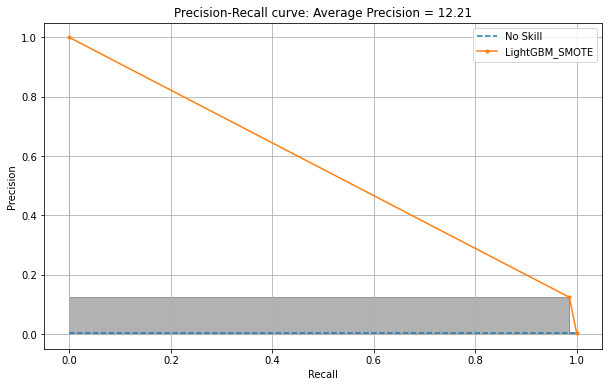

In [ ]:
# Obtain precision and recall 
precision, recall, _ = precision_recall_curve(y_test, y_pred)

plt.figure(figsize=(10,6))
# calculate the no skill line as the proportion of the positive class
no_skill = len(y[y==1]) / len(y)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='LightGBM_SMOTE')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(); plt.grid(True)
plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))
plt.show()